[*********************100%***********************]  60 of 60 completed


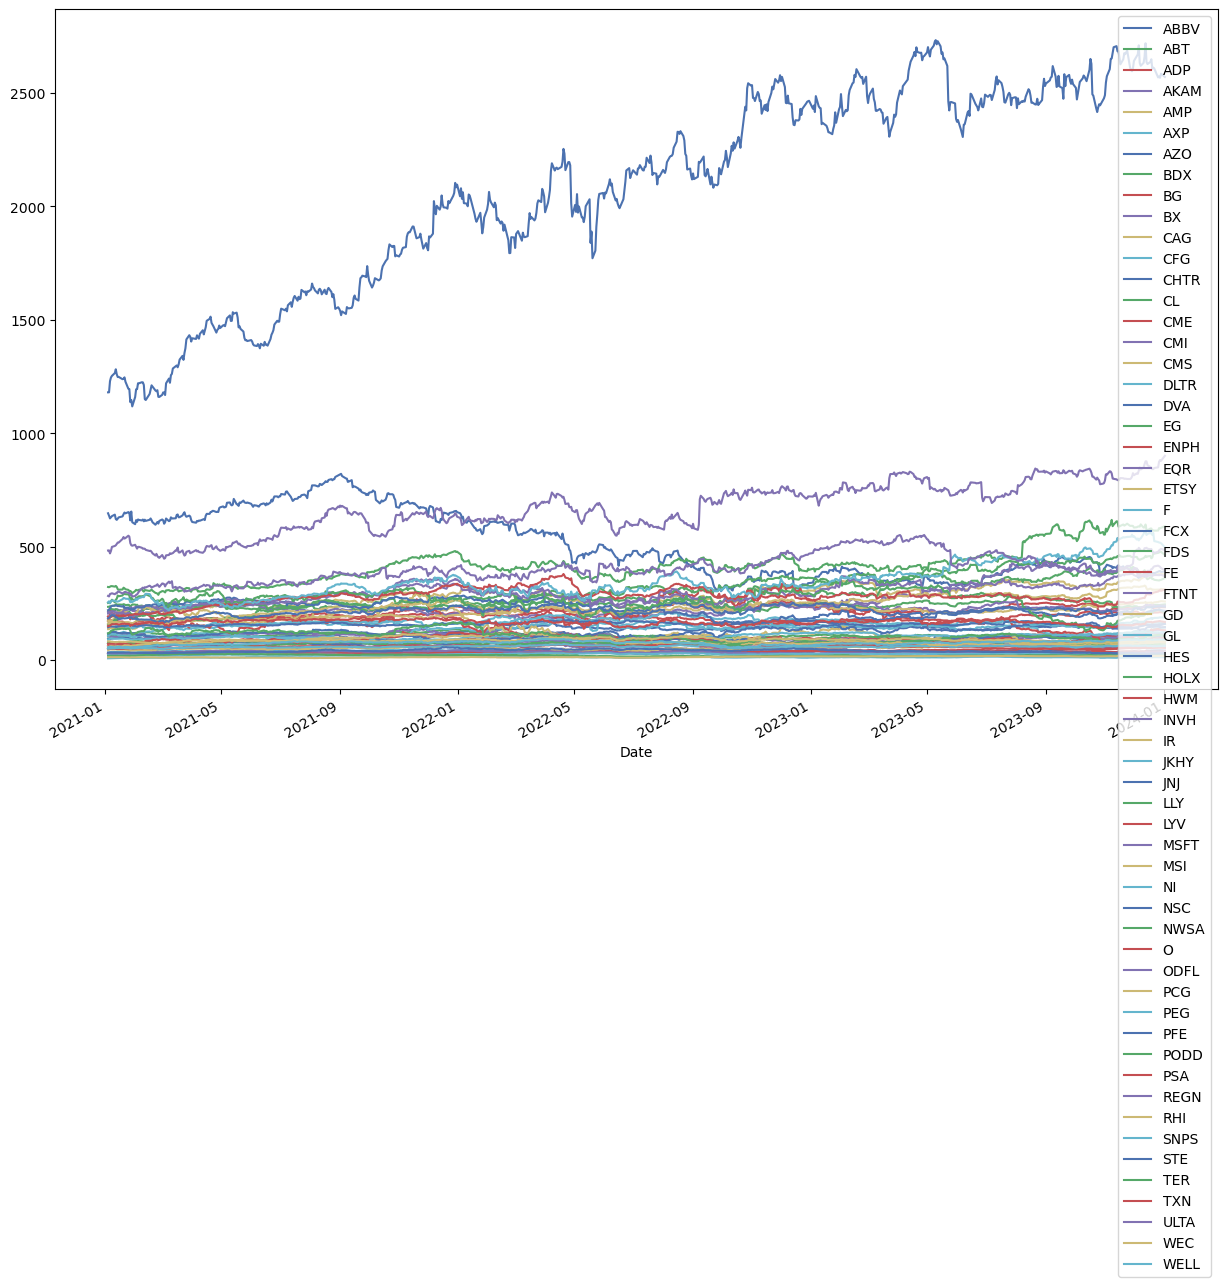

In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import HRPOpt, CLA, risk_models, expected_returns, risk_models, plotting
from tqdm import tqdm

# Set a random seed for reproducibility
np.random.seed(0)

# Number of stocks to select
x = 60  # You can change this value

# Load the CSV file
sp500_df = pd.read_csv('sp500.csv', delimiter=';')

# Extract the stock symbols
symbols = sp500_df['Symbol']

# Randomly select 'x' stocks
selected_symbols = np.random.choice(symbols, x, replace=False)

# Fetch historical data for the selected stocks
data = yf.download(selected_symbols.tolist(), period='max')['Adj Close']

# Drop any NaN values (in case some stocks don't have full data)
data = data.dropna()
# data = data.dropna(how='all')

prices = data[data.index >= "2021-01-01"]


prices.plot(figsize=(15,10));

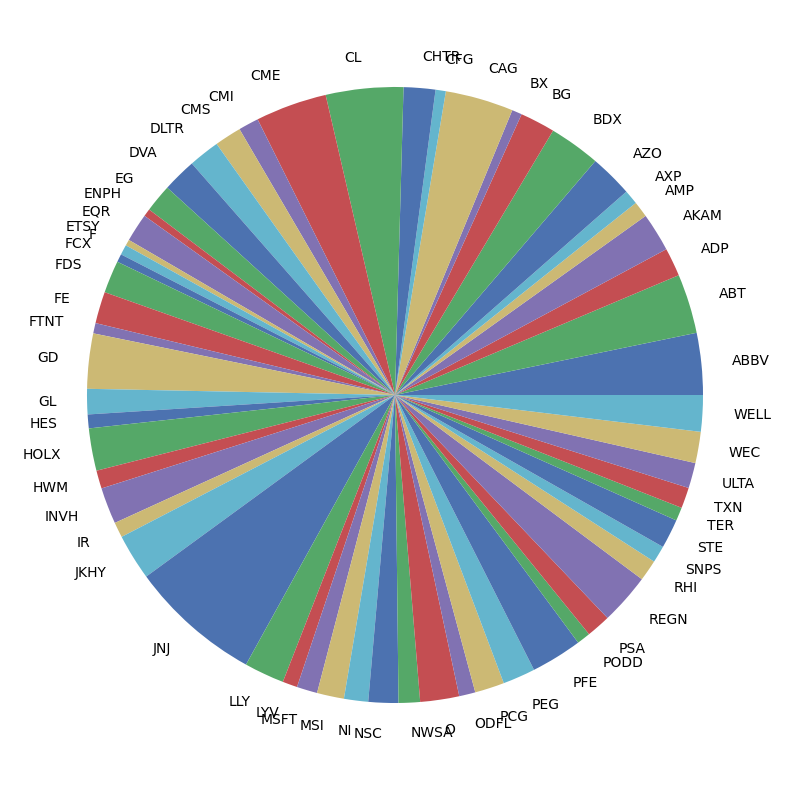

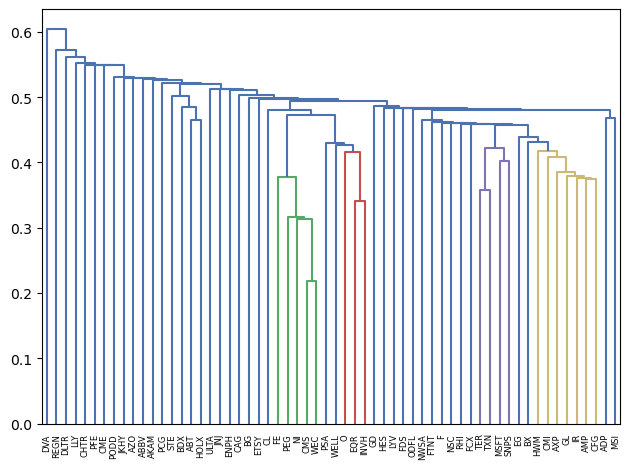

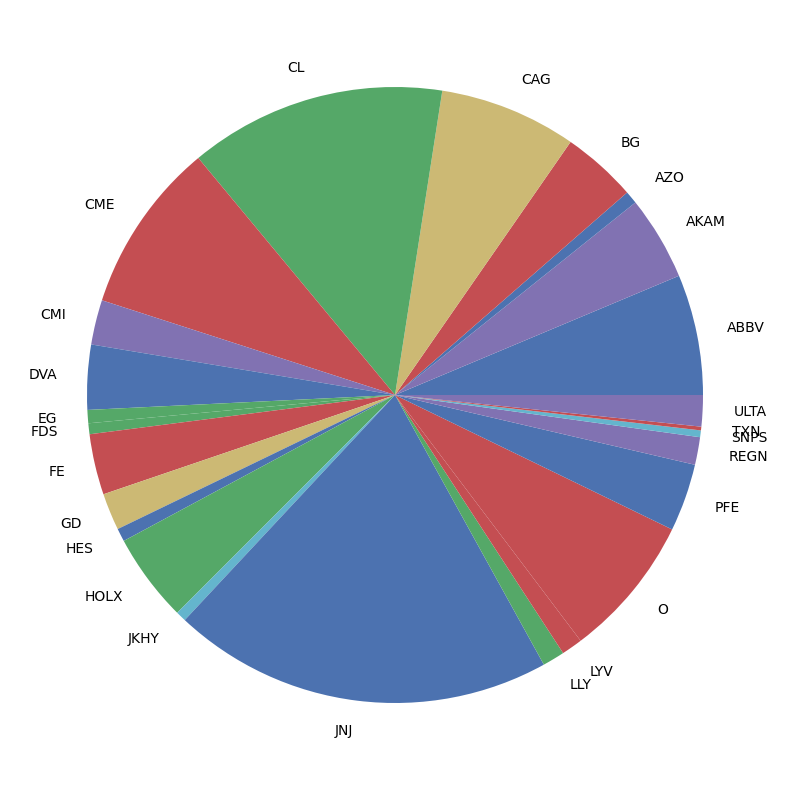

In [27]:
# Calculate expected returns and sample covariance
mu = expected_returns.returns_from_prices(prices)
# S = risk_models.sample_cov(prices, frequency=252)

# Sample covariance matrix should not be the default choice for CLA
# Try Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix.
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
mu_historical = expected_returns.mean_historical_return(prices, frequency=252)


# Optimize portfolio for HRP
hrp = HRPOpt(mu)
hrp.optimize()
hrp_weights = hrp.clean_weights()
pd.Series(hrp_weights).plot.pie(figsize=(10, 10));
plt.show()
plotting.plot_dendrogram(hrp)
plt.show()


# Optimize portfolio for CLA
cla = CLA(mu_historical, S)
cla_weights_min_vol = cla.min_volatility()
pd.Series(cla_weights_min_vol).plot.pie(figsize=(10, 10));
plt.show()


In [28]:
print("HRP Portfolio Performance:")
hrp.portfolio_performance(verbose=True)
print()
print("CLA Portfolio Performance:")
cla.portfolio_performance(verbose=True);

HRP Portfolio Performance:
Expected annual return: 12.9%
Annual volatility: 13.8%
Sharpe Ratio: 0.79

CLA Portfolio Performance:
Expected annual return: 7.0%
Annual volatility: 11.9%
Sharpe Ratio: 0.42


## In-Sample Weights

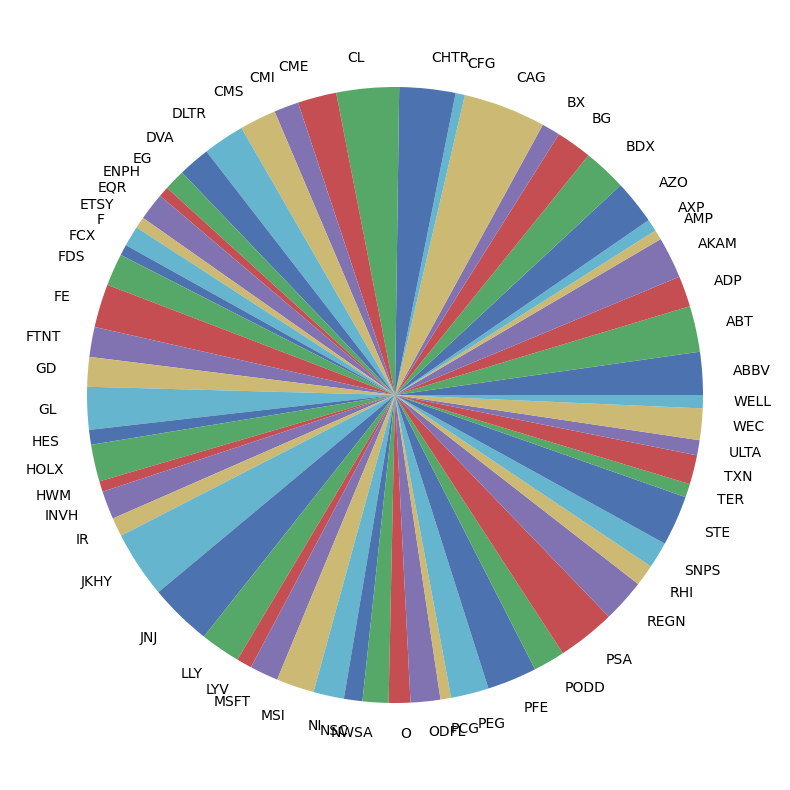

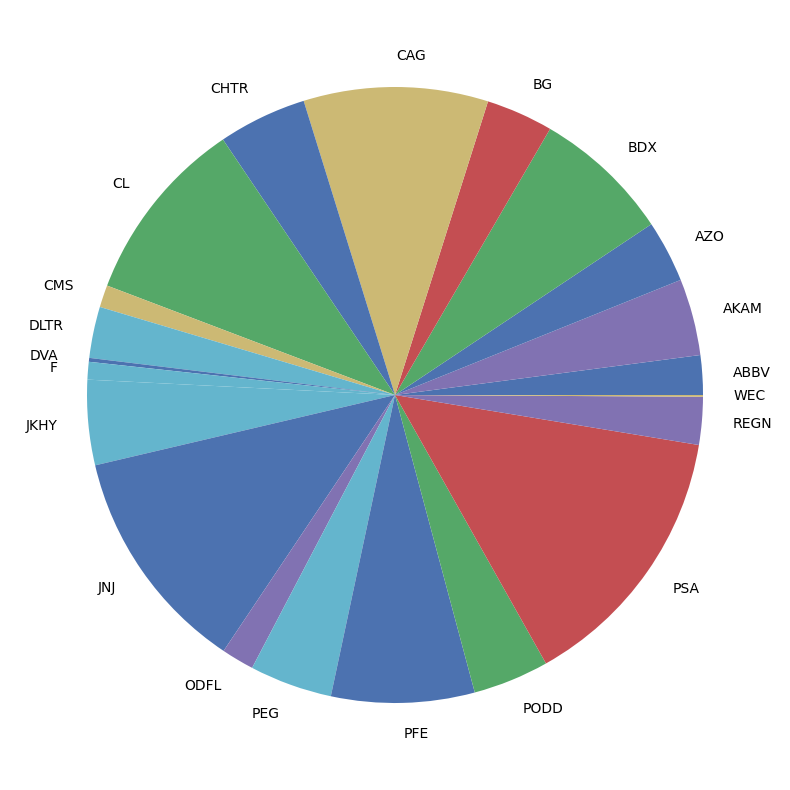

HRP Portfolio Performance (In-Sample):
Expected annual return: 12.9%
Annual volatility: 13.8%
Sharpe Ratio: 0.79

CLA Portfolio Performance (In-Sample):
Expected annual return: 7.0%
Annual volatility: 11.9%
Sharpe Ratio: 0.42


In [29]:
# Split Data into In-Sample and Out-of-Sample
split_date = '2022-01-01'
in_sample_data = data[data.index <= split_date]
out_sample_data = data[data.index >= split_date]


# In-Sample Portfolio Construction
mu_in_sample = expected_returns.returns_from_prices(in_sample_data)
mu_historical_in_sample = expected_returns.mean_historical_return(in_sample_data, frequency=252)
S_in_sample = risk_models.CovarianceShrinkage(in_sample_data).ledoit_wolf()
hrp_weights = HRPOpt(mu_in_sample).optimize()
cla_weights_min_vol = CLA(mu_historical_in_sample, S_in_sample).min_volatility()

# Get HRP Weights
pd.Series(hrp_weights).plot.pie(figsize=(10, 10));
plt.show()

# Get CLA Weights
pd.Series(cla_weights_min_vol).plot.pie(figsize=(10, 10));
plt.show()

print("HRP Portfolio Performance (In-Sample):")
hrp.portfolio_performance(verbose=True)
print()
print("CLA Portfolio Performance (In-Sample):")
cla.portfolio_performance(verbose=True);


## Out-of-Sample testing 

Processing: 100%|██████████| 23/23 [00:27<00:00,  1.18s/it]


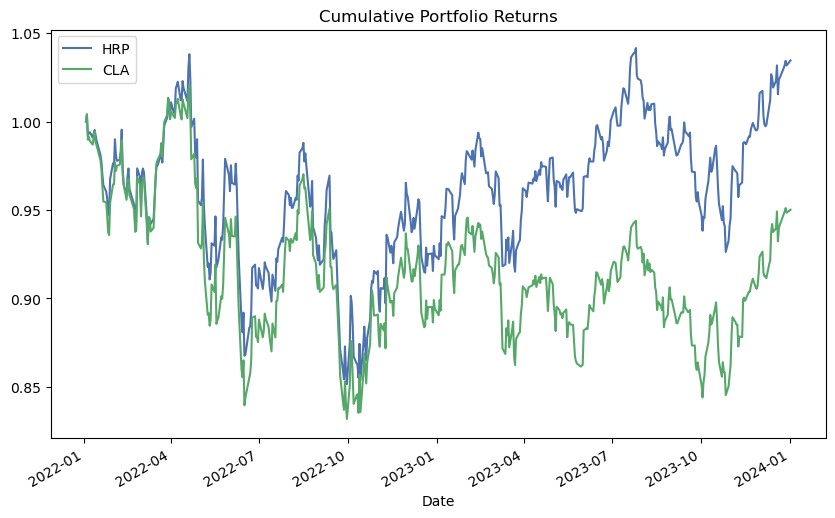

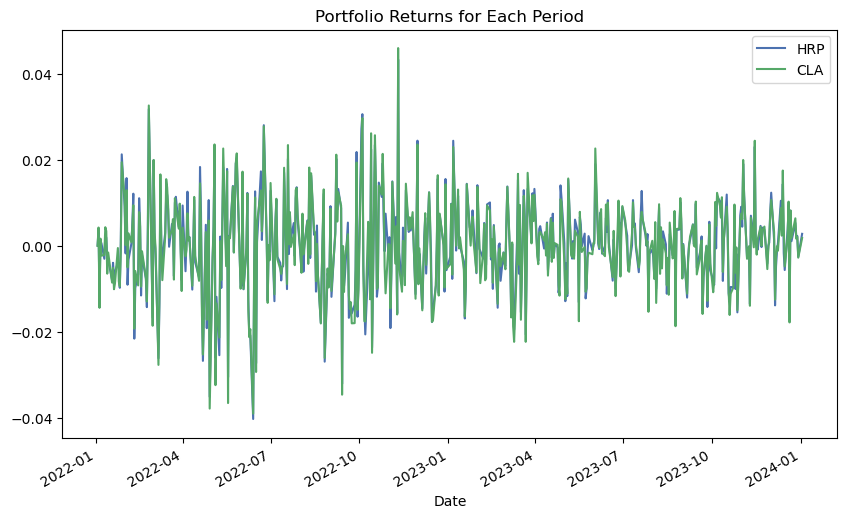

Volatility of HRP Portfolio: 0.1663621553766631
Volatility of CLA Portfolio: 0.17121880861819494


In [30]:


# In-Sample Portfolio Construction
mu_in_sample = expected_returns.returns_from_prices(in_sample_data)
mu_historical_in_sample = expected_returns.mean_historical_return(in_sample_data, frequency=252)
S_in_sample = risk_models.CovarianceShrinkage(in_sample_data).ledoit_wolf()
hrp = HRPOpt(mu_in_sample).optimize()
cla = CLA(mu_historical_in_sample, S_in_sample).min_volatility()

# Function to update the portfolio
def update_portfolio(data):
    mu = expected_returns.returns_from_prices(data)
    mu_historical = expected_returns.mean_historical_return(data, frequency=252)
    S = risk_models.CovarianceShrinkage(data).ledoit_wolf()
    hrp = HRPOpt(mu)
    hrp_opt = hrp.optimize()
    # hrp_opt = hrp.clean_weights()
    cla = CLA(mu_historical, S)
    cla_opt = cla.min_volatility()
    # cla_opt = cla.clean_weights()
    
    return hrp_opt, cla_opt


# Rebalance portfolios in the out-of-sample data
window_size = 22  # Approximately one month
portfolio_returns = pd.DataFrame(index=out_sample_data.index, columns=["HRP", "CLA"])
hrp_weights, cla_weights = hrp, cla

for start in tqdm(range(0, len(out_sample_data), window_size), desc="Processing"):
    end = min(start + window_size, len(out_sample_data))
    current_window_data = data.iloc[start:end]
    hrp_weights, cla_weights = update_portfolio(current_window_data)

    # Calculate portfolio returns for this window
    window_returns = out_sample_data.pct_change().iloc[start:end]
    portfolio_returns["HRP"].iloc[start:end] = (window_returns * hrp_weights).sum(axis=1)
    portfolio_returns["CLA"].iloc[start:end] = (window_returns * cla_weights).sum(axis=1)

# Calculate cumulative returns and final variance in returns
cumulative_returns = (1 + portfolio_returns).cumprod()
final_vol_hrp = (portfolio_returns["HRP"].var() * 252) ** 0.5
final_vol_cla = (portfolio_returns["CLA"].var() * 252) ** 0.5

# Plot cumulative returns
cumulative_returns.plot(figsize=(10, 6))
plt.title("Cumulative Portfolio Returns")
plt.show()

# Plotting just the returns for each period
portfolio_returns.plot(figsize=(10, 6))
plt.title("Portfolio Returns for Each Period")
plt.show()


# Print final variances
print("Volatility of HRP Portfolio:", final_vol_hrp)
print("Volatility of CLA Portfolio:", final_vol_cla)


